# Advection-diffusion problem

In this task, we'll simulate advection-diffusion in a fluid domain.

Natively, advection is not taken into account in FESTIM. The idea is therefore to modify the governing equations by adding an advection term.

In [1]:
import festim as F

my_model = F.HydrogenTransportProblem()

H = F.Species("H")
my_model.species = [H]

Create a mesh with FEniCS:

In [2]:
from dolfinx.mesh import create_unit_square
from mpi4py import MPI

# creating a mesh with FEniCS
nx = ny = 20
mesh_fenics = create_unit_square(MPI.COMM_WORLD, nx, ny)

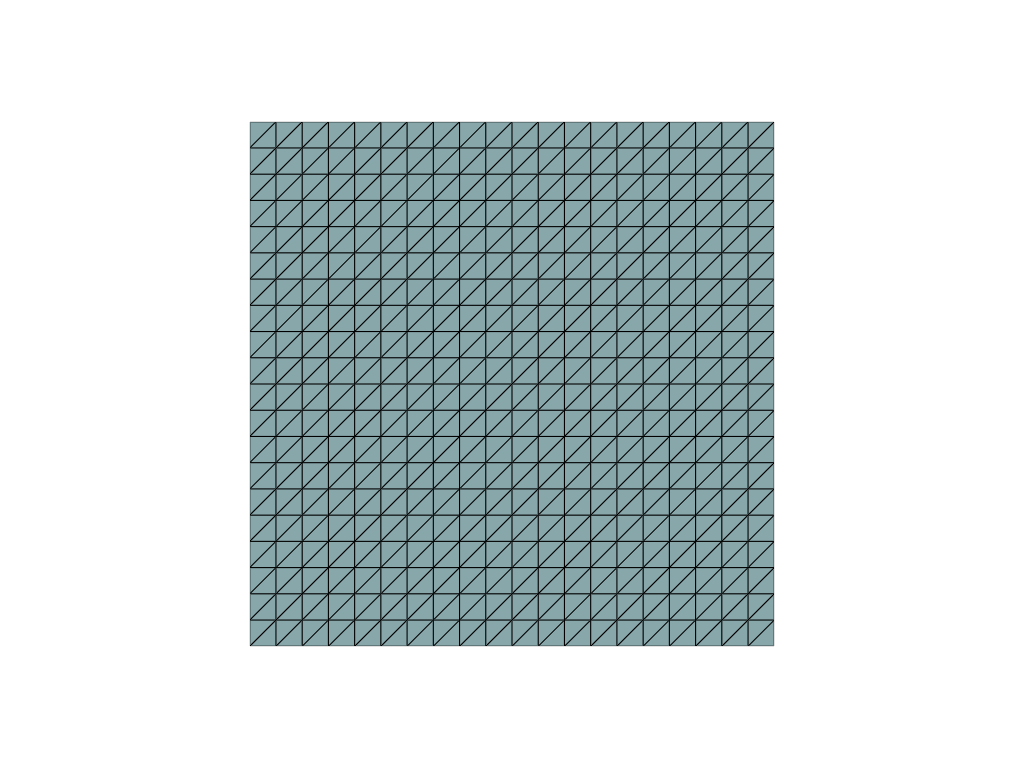

In [3]:
import pyvista
from dolfinx import plot

pyvista.start_xvfb()

tdim = mesh_fenics.topology.dim

mesh_fenics.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(mesh_fenics, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("mesh.png")

The mesh can now be passed to a `festim.Mesh` instance.

In [4]:
my_model.mesh = F.Mesh(mesh_fenics)

We create subdomains for volumes and boundaries

In [5]:
import numpy as np
import dolfinx


class TopBot(F.SurfaceSubdomain):
    def locate_boundary_facet_indices(self, mesh):
        return dolfinx.mesh.locate_entities_boundary(
            mesh,
            mesh.topology.dim - 1,
            lambda x: np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[1], 1.0)),
        )

class Left(F.SurfaceSubdomain):
    def locate_boundary_facet_indices(self, mesh):
        return dolfinx.mesh.locate_entities_boundary(
            mesh,
            mesh.topology.dim - 1,
            lambda x: np.isclose(x[0], 0.0),
        )

topbot_boundary = TopBot(id=1)
left_boundary = Left(id=2)
volume_subdomain = F.VolumeSubdomain(id=1, material=F.Material(D_0=1, E_D=0))

my_model.subdomains = [
    topbot_boundary,
    left_boundary,
    volume_subdomain,
]

Let's add the rest of the parameters.
For this case, the concentration will be set to 1 on the left surface and to zero on the top and bottom surfaces.

In [6]:
my_model.temperature = 500

my_model.boundary_conditions = [
    F.FixedConcentrationBC(species=H, subdomain=topbot_boundary, value=0),
    F.FixedConcentrationBC(species=H, subdomain=left_boundary, value=1),
]

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, transient=False)

We can now run the pure diffusion simulation and visualise the hydrogen concentration field.

In [7]:
my_model.initialise()
my_model.run()

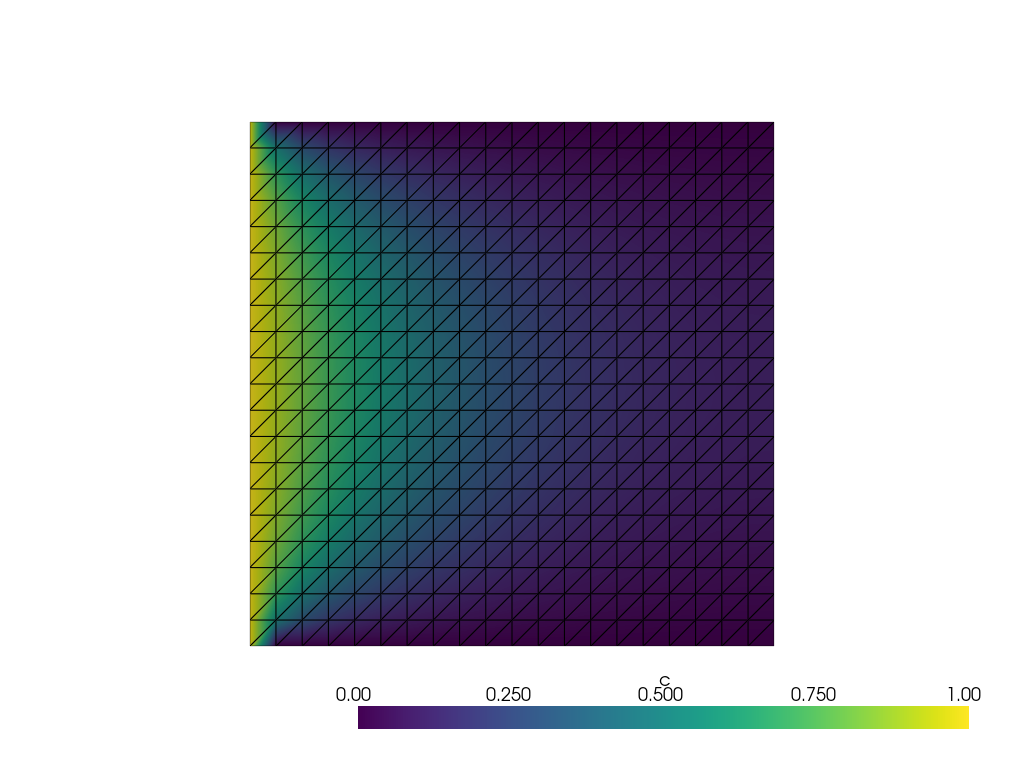

In [ ]:
hydrogen_concentration = H.solution

topology, cell_types, geometry = plot.vtk_mesh(hydrogen_concentration.function_space)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.point_data["c"] = hydrogen_concentration.x.array.real
u_grid.set_active_scalars("c")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()

if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("concentration_diff_only.png")

## Adding advection

Let's now add an advection term. To do so, we first need to create a velocity field.
For simplicity sake, we will create an arbitrary field `velocity`.

> 
> Note: this velocity field can be obtained from solving the Navier-Stokes equations with FEniCS or with another code (OpenFOAM).
> 

In [9]:
from basix.ufl import element

el = element("Lagrange", mesh_fenics.topology.cell_name(), 2, shape=(mesh_fenics.geometry.dim, ))


V = dolfinx.fem.functionspace(my_model.mesh.mesh, el)

velocity = dolfinx.fem.Function(V)

velocity.interpolate(lambda x: (-100*x[1]*(x[1]-1), np.full_like(x[0], 0.0)))

Here's what `velocity` looks like:

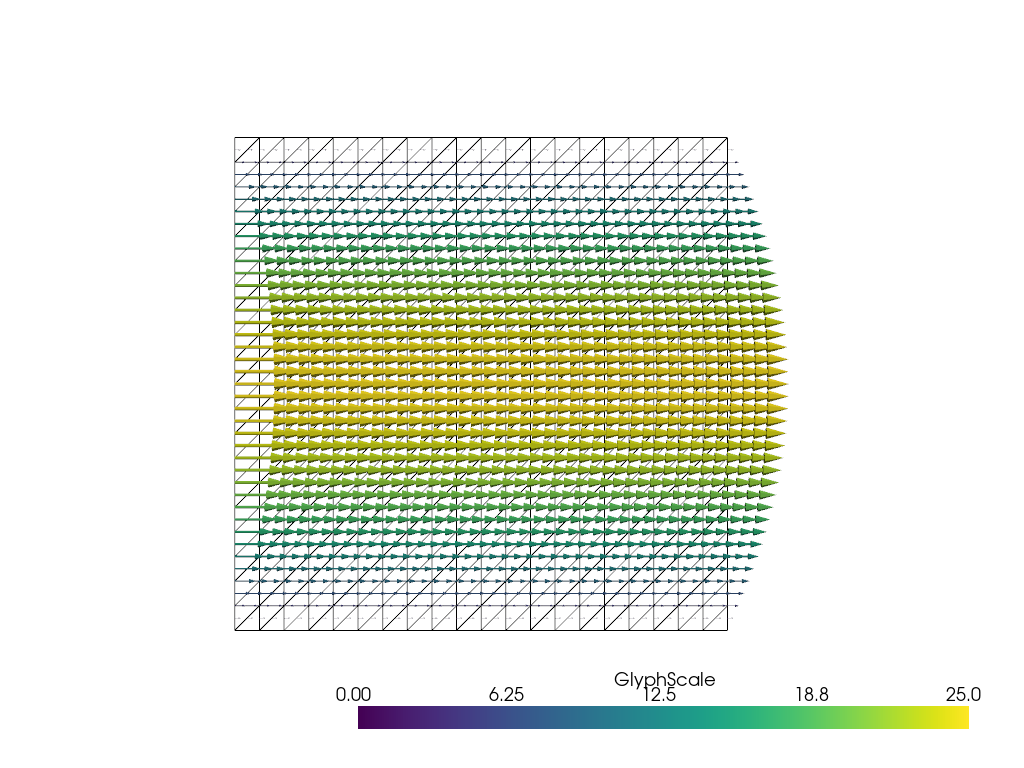

In [10]:
topology, cell_types, geometry = plot.vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(velocity)] = velocity.x.array.real.reshape((geometry.shape[0], len(velocity)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["v"] = values
glyphs = function_grid.glyph(orient="v", factor=0.005)

# Create a pyvista-grid for the mesh
mesh_fenics.topology.create_connectivity(mesh_fenics.topology.dim, mesh_fenics.topology.dim)
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(mesh_fenics, mesh_fenics.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

Now that we created a FEniCS function representing the velocity, let's add an advection term to the governing equation.

The governing equation for steady state advection-diffusion is:

$$\nabla \cdot (D \nabla c) - v \cdot \nabla c = 0$$

where $D$ is the diffusion coefficient, $c$ is the hydrogen concentration and $v$ is the velocity.


In [11]:
advection_term = F.AdvectionTerm(
    velocity=velocity,
    subdomain=volume_subdomain,
    species=H,
)

my_model.advection_terms = [advection_term]

In [12]:
my_model.initialise()
my_model.run()

Now that the governing equation has been modified, let's run the simulation again and check the new concentration field.

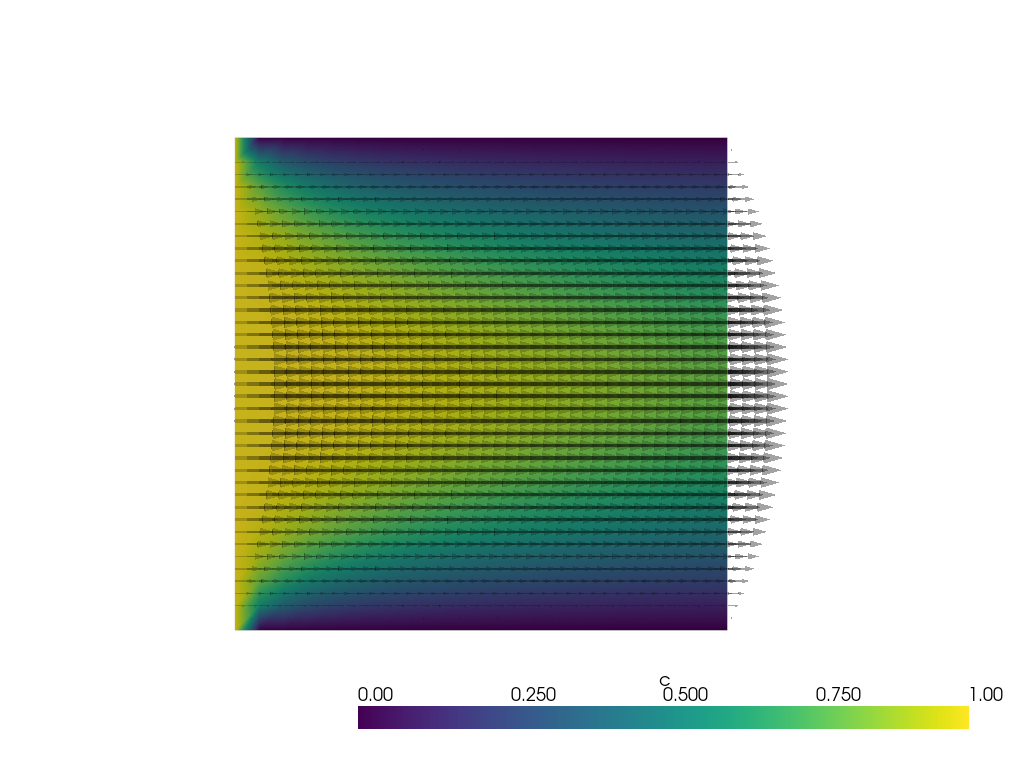

In [ ]:
hydrogen_concentration = H.solution

topology, cell_types, geometry = plot.vtk_mesh(hydrogen_concentration.function_space)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.point_data["c"] = hydrogen_concentration.x.array.real
u_grid.set_active_scalars("c")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False)
u_plotter.add_mesh(glyphs, color="black", opacity=0.2)
u_plotter.view_xy()

if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("concentration_with_adv.png")

The concentration field is greatly affected as particles are now pushed towards the right hand side of the domain.

# Task:

Vary the velocity field to investigate its influence on the mobile concentration